## Importing Packages

In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [3]:
from fl_mnist_implementation_utils import *

## Loading Dataset & Data Preprocessing

In [4]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        #im_gray_resized = cv2.resize(im_gray, (48,48), interpolation = cv2.INTER_AREA)
        #image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(im_gray/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

In [5]:
#declear path to your mnist data folder
img_path = r'D:\Important Files\Dataset Collection\Image Classification\Facial Expression\FER\train'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=1000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=7)

[INFO] processed 1000/28709
[INFO] processed 2000/28709
[INFO] processed 3000/28709
[INFO] processed 4000/28709
[INFO] processed 5000/28709
[INFO] processed 6000/28709
[INFO] processed 7000/28709
[INFO] processed 8000/28709
[INFO] processed 9000/28709
[INFO] processed 10000/28709
[INFO] processed 11000/28709
[INFO] processed 12000/28709
[INFO] processed 13000/28709
[INFO] processed 14000/28709
[INFO] processed 15000/28709
[INFO] processed 16000/28709
[INFO] processed 17000/28709
[INFO] processed 18000/28709
[INFO] processed 19000/28709
[INFO] processed 20000/28709
[INFO] processed 21000/28709
[INFO] processed 22000/28709
[INFO] processed 23000/28709
[INFO] processed 24000/28709
[INFO] processed 25000/28709
[INFO] processed 26000/28709
[INFO] processed 27000/28709
[INFO] processed 28000/28709


## Creation of Local Clients & Data Distribution

In [6]:
def create_clients(image_list, label_list, num_clients=3, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [7]:
#create clients
clients = create_clients(X_train, y_train, num_clients=3, initial='client')

In [8]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [9]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the train set  
train_batched = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(len(y_train))
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

## Building CNN Model

In [10]:
class CNNModel:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.1))
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [12]:
lr = 0.001 
comms_round = 20
loss='categorical_crossentropy'
metrics = ['accuracy']
#optimizer = SGD(learning_rate=lr, 
#                decay=lr / comms_round, 
#                momentum=0.9
#               )
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

## Training & Aggregating for Federated Implementation

In [13]:
Accu = []
Loss = []
Tr_Accu = []
Tr_Loss =[]

In [14]:
#initialize global model
mcnn_global = CNNModel()
global_model = mcnn_global.build((48, 48, 1), 7)
        
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        mcnn_local = CNNModel()
        local_model = mcnn_local.build((48, 48, 1), 7)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=5, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_train, y_train) in train_batched:
        global_train_acc, global_train_loss = test_train_model(X_train, y_train, global_model, comm_round)
        Tr_Accu.append(global_train_acc)
        Tr_Loss.append(global_train_loss)
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)
        Accu.append(global_acc)
        Loss.append(global_loss)

comm_round: 0 | global_training_acc: 25.033% | global_training_loss: 1.9071686267852783
comm_round: 0 | global_acc: 26.019% | global_loss: 1.904741644859314
comm_round: 1 | global_training_acc: 30.877% | global_training_loss: 1.8691132068634033
comm_round: 1 | global_acc: 31.243% | global_loss: 1.8660204410552979
comm_round: 2 | global_training_acc: 48.816% | global_training_loss: 1.7250711917877197
comm_round: 2 | global_acc: 48.206% | global_loss: 1.728532314300537
comm_round: 3 | global_training_acc: 59.683% | global_training_loss: 1.6174254417419434
comm_round: 3 | global_acc: 55.486% | global_loss: 1.645775556564331
comm_round: 4 | global_training_acc: 67.265% | global_training_loss: 1.522240400314331
comm_round: 4 | global_acc: 60.362% | global_loss: 1.5803794860839844
comm_round: 5 | global_training_acc: 69.762% | global_training_loss: 1.4883837699890137
comm_round: 5 | global_acc: 59.282% | global_loss: 1.5739998817443848
comm_round: 6 | global_training_acc: 76.902% | global_tr

In [15]:
#commence global training loop
for comm_round in range(5):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        mcnn_local = CNNModel()
        local_model = mcnn_local.build((48, 48, 1), 7)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=5, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_train, y_train) in train_batched:
        global_train_acc, global_train_loss = test_train_model(X_train, y_train, global_model, comm_round)
        Tr_Accu.append(global_train_acc)
        Tr_Loss.append(global_train_loss)
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)
        Accu.append(global_acc)
        Loss.append(global_loss)

comm_round: 0 | global_training_acc: 98.634% | global_training_loss: 1.1883126497268677
comm_round: 0 | global_acc: 64.681% | global_loss: 1.5156676769256592
comm_round: 1 | global_training_acc: 98.916% | global_training_loss: 1.1845948696136475
comm_round: 1 | global_acc: 63.950% | global_loss: 1.5163156986236572
comm_round: 2 | global_training_acc: 99.172% | global_training_loss: 1.1806602478027344
comm_round: 2 | global_acc: 65.343% | global_loss: 1.510393500328064
comm_round: 3 | global_training_acc: 99.226% | global_training_loss: 1.179580569267273
comm_round: 3 | global_acc: 65.552% | global_loss: 1.5101901292800903
comm_round: 4 | global_training_acc: 99.164% | global_training_loss: 1.180925726890564
comm_round: 4 | global_acc: 64.751% | global_loss: 1.5171552896499634


In [16]:
#commence global training loop
for comm_round in range(5):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        mcnn_local = CNNModel()
        local_model = mcnn_local.build((48, 48, 1), 7)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=5, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_train, y_train) in train_batched:
        global_train_acc, global_train_loss = test_train_model(X_train, y_train, global_model, comm_round)
        Tr_Accu.append(global_train_acc)
        Tr_Loss.append(global_train_loss)
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)
        Accu.append(global_acc)
        Loss.append(global_loss)

comm_round: 0 | global_training_acc: 99.369% | global_training_loss: 1.176662802696228
comm_round: 0 | global_acc: 65.796% | global_loss: 1.5093566179275513
comm_round: 1 | global_training_acc: 99.435% | global_training_loss: 1.1760485172271729
comm_round: 1 | global_acc: 65.691% | global_loss: 1.508980393409729
comm_round: 2 | global_training_acc: 99.447% | global_training_loss: 1.1752562522888184
comm_round: 2 | global_acc: 65.726% | global_loss: 1.508803367614746
comm_round: 3 | global_training_acc: 99.497% | global_training_loss: 1.1745280027389526
comm_round: 3 | global_acc: 65.413% | global_loss: 1.509761929512024
comm_round: 4 | global_training_acc: 99.628% | global_training_loss: 1.1720694303512573
comm_round: 4 | global_acc: 65.587% | global_loss: 1.508871078491211


In [17]:
#commence global training loop
for comm_round in range(5):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        mcnn_local = CNNModel()
        local_model = mcnn_local.build((48, 48, 1), 7)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=5, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_train, y_train) in train_batched:
        global_train_acc, global_train_loss = test_train_model(X_train, y_train, global_model, comm_round)
        Tr_Accu.append(global_train_acc)
        Tr_Loss.append(global_train_loss)
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)
        Accu.append(global_acc)
        Loss.append(global_loss)

comm_round: 0 | global_training_acc: 99.594% | global_training_loss: 1.1727808713912964
comm_round: 0 | global_acc: 64.542% | global_loss: 1.5137380361557007
comm_round: 1 | global_training_acc: 99.621% | global_training_loss: 1.171311855316162
comm_round: 1 | global_acc: 65.064% | global_loss: 1.5102020502090454
comm_round: 2 | global_training_acc: 99.609% | global_training_loss: 1.1715511083602905
comm_round: 2 | global_acc: 65.378% | global_loss: 1.5069102048873901
comm_round: 3 | global_training_acc: 99.644% | global_training_loss: 1.1705379486083984
comm_round: 3 | global_acc: 65.204% | global_loss: 1.5089365243911743
comm_round: 4 | global_training_acc: 99.656% | global_training_loss: 1.1706880331039429
comm_round: 4 | global_acc: 65.413% | global_loss: 1.5073859691619873


In [18]:
#commence global training loop
for comm_round in range(5):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        mcnn_local = CNNModel()
        local_model = mcnn_local.build((48, 48, 1), 7)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=5, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_train, y_train) in train_batched:
        global_train_acc, global_train_loss = test_train_model(X_train, y_train, global_model, comm_round)
        Tr_Accu.append(global_train_acc)
        Tr_Loss.append(global_train_loss)
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)
        Accu.append(global_acc)
        Loss.append(global_loss)

comm_round: 0 | global_training_acc: 99.710% | global_training_loss: 1.169805884361267
comm_round: 0 | global_acc: 66.040% | global_loss: 1.50443434715271
comm_round: 1 | global_training_acc: 99.741% | global_training_loss: 1.169114589691162
comm_round: 1 | global_acc: 66.144% | global_loss: 1.502865195274353
comm_round: 2 | global_training_acc: 99.721% | global_training_loss: 1.1694810390472412
comm_round: 2 | global_acc: 65.657% | global_loss: 1.5059698820114136
comm_round: 3 | global_training_acc: 99.725% | global_training_loss: 1.1690593957901
comm_round: 3 | global_acc: 65.796% | global_loss: 1.5032628774642944
comm_round: 4 | global_training_acc: 99.748% | global_training_loss: 1.16879403591156
comm_round: 4 | global_acc: 65.970% | global_loss: 1.5022674798965454


In [19]:
#commence global training loop
for comm_round in range(10):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        mcnn_local = CNNModel()
        local_model = mcnn_local.build((48, 48, 1), 7)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=5, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_train, y_train) in train_batched:
        global_train_acc, global_train_loss = test_train_model(X_train, y_train, global_model, comm_round)
        Tr_Accu.append(global_train_acc)
        Tr_Loss.append(global_train_loss)
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)
        Accu.append(global_acc)
        Loss.append(global_loss)

comm_round: 0 | global_training_acc: 99.694% | global_training_loss: 1.169083833694458
comm_round: 0 | global_acc: 66.109% | global_loss: 1.5033321380615234
comm_round: 1 | global_training_acc: 99.752% | global_training_loss: 1.168438196182251
comm_round: 1 | global_acc: 66.318% | global_loss: 1.5023103952407837
comm_round: 2 | global_training_acc: 99.772% | global_training_loss: 1.168513298034668
comm_round: 2 | global_acc: 65.413% | global_loss: 1.5070348978042603
comm_round: 3 | global_training_acc: 99.768% | global_training_loss: 1.1684163808822632
comm_round: 3 | global_acc: 65.308% | global_loss: 1.5054563283920288
comm_round: 4 | global_training_acc: 99.756% | global_training_loss: 1.168697476387024
comm_round: 4 | global_acc: 65.935% | global_loss: 1.5051239728927612
comm_round: 5 | global_training_acc: 99.764% | global_training_loss: 1.168330430984497
comm_round: 5 | global_acc: 65.099% | global_loss: 1.507287621498108
comm_round: 6 | global_training_acc: 99.776% | global_trai

ResourceExhaustedError:  OOM when allocating tensor with shape[256,256,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/conv2d_7/Conv2D/Conv2DBackpropFilter
 (defined at C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1468823]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential/conv2d_7/Conv2D/Conv2DBackpropFilter:
In[0] sequential/batch_normalization_6/FusedBatchNormV3 (defined at C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\layers\normalization\batch_normalization.py:589)	
In[1] gradient_tape/sequential/conv2d_7/Conv2D/ShapeN:	
In[2] gradient_tape/sequential/conv2d_7/ReluGrad:

Operation defined at: (most recent call last)
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\USER\AppData\Local\Temp/ipykernel_20928/2906472526.py", line 26, in <module>
>>>     local_model.fit(clients_batched[client], epochs=5, verbose=0)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\engine\training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "C:\Users\USER\anaconda3\envs\tf-keras-gpu-test\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

## Evaluation

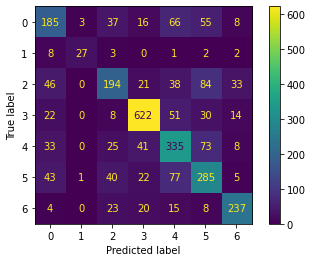

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred = global_model.predict(X_test)
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

y_pred_proba = global_model.predict(X_test)

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)       

ROC_AUC Score: 0.8984413090996497
Cohen_Kappa Score: 0.5821743448683847
F1 Score: 0.650319227255787
Matthews Correlation Coefficient: 0.5829144793769877
Log Loss: 2.041936348566463
Accuracy: 0.6565656565656566


Text(0, 0.5, 'Loss')

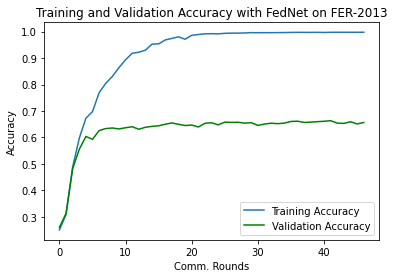

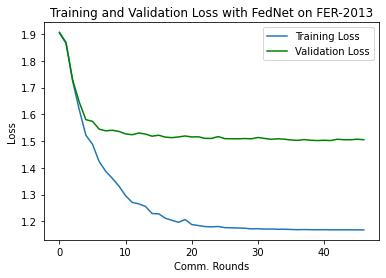

In [22]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = Tr_Accu
val_acc  = Accu
loss     = Tr_Loss
val_loss = Loss

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.title ('Training and Validation Accuracy with FedNet on FER-2013')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.title ('Training and Validation Loss with FedNet on FER-2013')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Loss')